In [390]:
import numpy as np
import pandas as pd
from scipy.integrate import ode, solve_ivp
import altair as alt
alt.data_transformers.disable_max_rows()


DataTransformerRegistry.enable('default')

In [391]:
def sir_ode(times,init,parms):
    beta, epsilon0, epsilon1, alpha, delta, gamma, c, n_icu, p_icu, CFR0, CFR1, N, epsilon0, epsilon1, intervention_time, intervention_factor = parms
    S,E,P,I0,I1,R0,R1 = init
    # ODEs
    I = I0 + I1
    if I > 0:
        CFR = CFR1 - min(1, n_icu / (N*I*p_icu))*(CFR1 - CFR0)
    else:
        CFR = CFR0
    dS = -beta*S*(epsilon0*P + I0 + epsilon1*I1)
    dE = beta*S*(epsilon0*P + I0 + epsilon1*I1) - alpha*E
    dP = alpha*E - delta*P
    dI0 = delta*P - (gamma + c)*I0
    dI1 = c*I0 - gamma*I1
    dR0 = gamma*(1-CFR)*I0
    dR1 = gamma*(1-CFR)*I1
    return [dS,dE,dP,dI0,dI1,dR0,dR1]

In [392]:
N = 8000000
reproduction_num = 2.5
alpha = 0.25
epsilon0 = 0.15
epsilon1 = 1
delta = 1
gamma = 0.1
c = 0.1
CFR0 = 0.01
CFR1 = 0.02
p_icu = 0.0125
n_icu = 300 # beds
intervention_time = 200
intervention_factor = 0.4


beta = reproduction_num/(epsilon0/delta + 1/gamma)

parms = [beta, epsilon0, epsilon1, alpha, delta, gamma, c, n_icu, p_icu, CFR0, CFR1, N, epsilon0, epsilon1, intervention_time, intervention_factor]
S = 1 - 20/N
E = 20/N
P = 0
I0 = 0
I1 = 0
R0 = 0
R1 = 0
init = [S,E,P,I0,I1,R0,R1]
times = np.linspace(0,300,2000)

In [393]:
sir_sol = solve_ivp(fun=lambda t, y: sir_ode(t, y, parms), t_span=[min(times),max(times)], y0=init, t_eval=times, rtol=1e-8)

In [394]:
sir_sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 512
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 1.50075038e-01, 3.00150075e-01, ...,
       2.99699850e+02, 2.99849925e+02, 3.00000000e+02])
 t_events: None
        y: array([[9.99997500e-01, 9.99997500e-01, 9.99997498e-01, ...,
        7.47461524e-01, 7.46713985e-01, 7.45966174e-01],
       [2.50000000e-06, 2.40826675e-06, 2.32078264e-06, ...,
        1.95232901e-02, 1.95380619e-02, 1.95525565e-02],
       [0.00000000e+00, 8.54561489e-08, 1.55873743e-07, ...,
        4.85320020e-03, 4.85731848e-03, 4.86137011e-03],
       ...,
       [0.00000000e+00, 3.44956112e-11, 2.52017967e-10, ...,
        2.04788608e-02, 2.05203809e-02, 2.05617316e-02],
       [0.00000000e+00, 3.41602824e-11, 2.51317168e-10, ...,
        1.00615874e-01, 1.00958298e-01, 1.01301166e-01],
       [0.00000000e+00, 9.62729571e-15, 1.81938024e-12, ...,
        8.04976

In [395]:
sir_out = pd.DataFrame({"t":sir_sol["t"],"S":sir_sol["y"][0],"E":sir_sol["y"][1],"P":sir_sol["y"][2],"I0":sir_sol["y"][3],"I1":sir_sol["y"][4],"R0":sir_sol["y"][5],"R1":sir_sol["y"][6]})

In [396]:
sir_out["D"] = 1 - sir_out["S"] - sir_out["E"] - sir_out["P"] - sir_out["I0"] - sir_out["I1"] - sir_out["R0"] - sir_out["R1"]

In [397]:
sir_out = sir_out * N
sir_out['t'] = sir_out['t']/N

#### Visualisation

In [398]:
plot_values = sir_out.melt('t')
plot_values = plot_values[(plot_values['variable'] != 'S') & (plot_values['variable'] != 'R1')& (plot_values['variable'] != 'R0')]

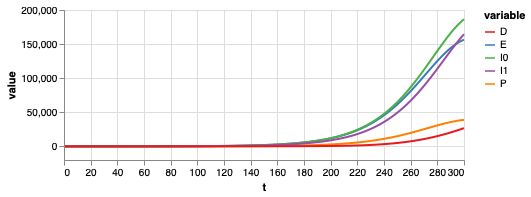

In [399]:
alt.Chart(plot_values, height=150).mark_line().encode(
    x='t',
    y='value',
    color=alt.Color('variable', scale=alt.Scale(scheme="set1"))
).properties(
)

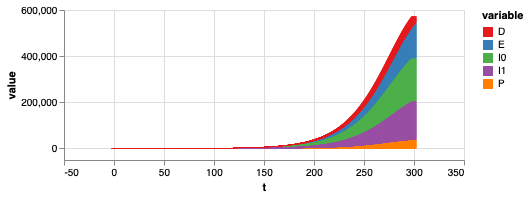

In [400]:
alt.Chart(plot_values, height=150).mark_bar().encode(
    x='t',
    y=alt.Y('value', stack=True),
    color=alt.Color('variable', scale=alt.Scale(scheme="set1"))
).properties(
).interactive()